In [ ]:
# ok what are we thinking here? 
# some ideas 
# can identify mix rate based on agreement in the mix rate groups across seeds
# # in other words, in the target training set, for a given set of classifiers, whats the 
    # probability that another set of classifiers agree that an instance caused disagreement 
    # need to think abotu ahow to aggregate this and other possibel metrics

In [ ]:
# so maybe to start a I take a purely data analysis approach to this 
# ok yeah so lets look at source accuracy of topk 0.5 (schedule) across mix rates (at low validation point)

In [1]:
import os
os.chdir("/nas/ucb/oliveradk/diverse-gen/")

In [2]:
import json
from functools import partial
from itertools import product
from typing import Optional, Literal, Callable
from tqdm import tqdm
from collections import defaultdict
from dataclasses import dataclass
from pathlib import Path
from copy import deepcopy
from datetime import datetime
from collections import defaultdict

import submitit
from submitit.core.utils import CommandFunction
import nevergrad as ng
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go

from losses.loss_types import LossType
from utils.exp_utils import get_executor, get_executor_local, run_experiments, get_conf_dir
from utils.proc_data_utils import get_exp_metrics, get_max_acc, get_acc_results

In [3]:
EXP_DIR = "output/cc_mix_rate_schedule_sweep"

In [34]:
datasets = ["cifar_mnist", "fmnist_mnist", "waterbirds", "celebA-0", "toy_grid"]
methods = ["TopK 0.5", "TopK 0.1"]
MIX_RATES = [0.1, 0.25, 0.5, 0.75, 1.0]
seeds = [1, 2, 3]

configs = {}
for dataset, method, mix_rate, seed in product(datasets, methods, MIX_RATES, seeds):
    configs[(dataset, method, mix_rate, seed)] = {
        "dataset": dataset,
        "method": method,
        "mix_rate": mix_rate,
        "seed": seed, 
        "exp_dir": get_conf_dir((dataset, method, mix_rate, seed), EXP_DIR)
    }
configs_by_dataset_method = defaultdict(lambda:defaultdict(list))
for conf in configs.values():
    configs_by_dataset_method[conf["dataset"]][conf["method"]].append(conf)

In [35]:

# get average accs (by val loss) for each experiment
acc_results = defaultdict(lambda:defaultdict(list))
for ds_name, method_dict in configs_by_dataset_method.items():
    for method_name, exps in method_dict.items():
        acc_results[ds_name][method_name] = get_acc_results(
            exps, model_selection="val_loss", acc_metric="val_source_acc", verbose=True
        )


# load results 
# compute mean source acc 

In [36]:
FIGSIZE = (3., 2.5)
FONTSIZE = 12
TICK_FONTSIZE = 10

def plot_acc_results_grid(
    results_dict: dict,
    nrows: int = 2,
    ncols: int = 3,
    ignored_loss_types: list[str] = [],
    figsize: tuple[float, float] = (9, 6),
    ylim: tuple[float, float] = (0.5, 1.0),
    fontsize: int = FONTSIZE,
    tick_fontsize: int = TICK_FONTSIZE,
    xlabel: str = "Mix Rate",
    ylabel: str = "Accuracy",
    dataset_titles: dict[str, str] = {},
):
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()
    
    for idx, (ds_name, method_dict) in enumerate(results_dict.items()):
        ax = axes[idx]
        
        for loss_type, loss_results in method_dict.items():
            if loss_type in ignored_loss_types:
                continue
            
            if isinstance(loss_type, LossType):
                loss_type = loss_type.name 
            
            if loss_type == LossType.ERM.name:
                results = [r for result in loss_results.values() for r in result]
                means = [np.mean(results) for _ in range(len(MIX_RATES))]
                stds = [np.std(results) for _ in range(len(MIX_RATES))]
                line_style = '--'
                marker = None
            else:
                means = [np.mean(loss_results[mix_rate]) for mix_rate in MIX_RATES]
                stds = [np.std(loss_results[mix_rate]) for mix_rate in MIX_RATES]
                line_style = '-'
                marker = 'o'
            
            ax.plot(MIX_RATES, means, label=loss_type, marker=marker, linestyle=line_style)
            ax.fill_between(MIX_RATES, 
                          [m - s for m, s in zip(means, stds)],
                          [m + s for m, s in zip(means, stds)],
                          alpha=0.2)

        x_labels = [str(mix_rate) for mix_rate in MIX_RATES]
        ax.set_xticks(MIX_RATES)
        ax.set_xticklabels(x_labels, fontsize=tick_fontsize)
        ax.tick_params(axis='both', labelsize=tick_fontsize)
        title = dataset_titles.get(ds_name, ds_name) if dataset_titles else ds_name
        ax.set_title(title, fontsize=fontsize)
        ax.set_ylim(*ylim)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    # Add a single legend for the entire figure
    handles, labels = axes[0].get_lines(), [line.get_label() for line in axes[0].get_lines()]
    fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, 1.05), ncol=len(methods))

    fig.supxlabel(xlabel, fontsize=fontsize)
    fig.supylabel(ylabel, fontsize=fontsize)
    
    fig.tight_layout()
    return fig, axes

dataset_titles = {
    "toy_grid": "Toy Grid",
    "fmnist_mnist": "FMNIST+MNIST",
    "cifar_mnist": "CIFAR+MNIST",
    "waterbirds": "Waterbirds",
    "celebA-0": "CelebA",
    "multi-nli": "MultiNLI"
}

In [37]:
acc_results["cifar_mnist"] = dict(acc_results["cifar_mnist"])

(<Figure size 900x600 with 6 Axes>,
 array([<Axes: title={'center': 'cifar_mnist'}>,
        <Axes: title={'center': 'fmnist_mnist'}>,
        <Axes: title={'center': 'waterbirds'}>,
        <Axes: title={'center': 'celebA-0'}>,
        <Axes: title={'center': 'toy_grid'}>, <Axes: >], dtype=object))

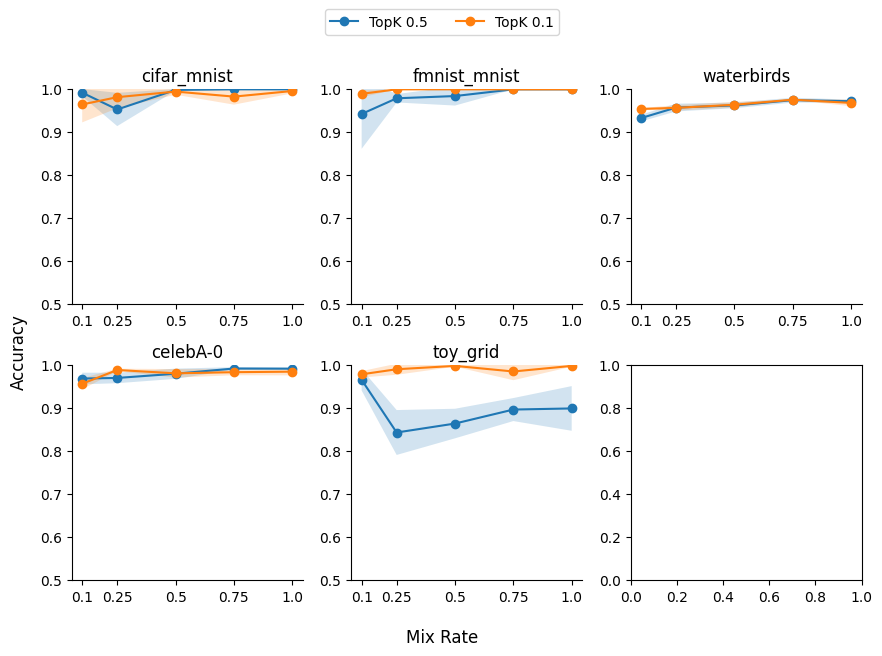

In [38]:
plot_acc_results_grid(acc_results)

In [10]:
acc_results

defaultdict(<function __main__.<lambda>()>,
            {'cifar_mnist': defaultdict(list,
                         {'TopK 0.5': {0.1: [0.98046875, 0.99609375, 1.0],
                           0.25: [0.90234375, 0.9609375, 0.99609375],
                           0.5: [1.0, 0.99609375, 1.0],
                           0.75: [1.0, 1.0, 1.0],
                           1.0: [1.0, 1.0, 1.0]},
                          'TopK 0.1': {0.1: [0.98828125, 0.90625, 1.0],
                           0.25: [1.0, 1.0, 0.9453125],
                           0.5: [1.0, 0.984375, 1.0],
                           0.75: [0.9921875, 1.0, 0.95703125],
                           1.0: [1.0, 0.98828125, 1.0]}}),
             'fmnist_mnist': defaultdict(list,
                         {'TopK 0.5': {0.1: [0.828125, 1.0, 1.0],
                           0.25: [0.9765625, 0.96875, 0.9921875],
                           0.5: [1.0, 1.0, 0.953125],
                           0.75: [1.0, 1.0, 1.0],
                      

In [ ]:
# cross referencing the test accuracy, the heuristic of "highest mix rate that doesn't hurt source acc" 
# seems pretty reasonable

# in order to do this efficiently, probably wouldn't be able to hyperparameter tune aux weight for all assumed mix rates
# well no you could just hyperparameter tune over both, then pick mix rate and optimize over aux weight

In [ ]:
# ok to experiment with this, we want to 
# I guess do larger mix rate sweep (intervals of 0.1) using reasonable aux weight values based on prior searches
# for each "actual" mix rate, pick the assumed mix rate that satisifies the heuristic 
    # probably should formalize the heuristic as "mean source acc within one standard deviation of ERM source acc"

In [ ]:
# ok I think I have everything, just need to think about target of final output

# plot source acc and test acc in two columns for each method
# plot peformance of selected mix rate topk compared to mix rates and other methods
# plot correlation between source acc dif (with ERM) and max(assumed mix rate - mix_rate, 0) (expecting positive)

# ok seems good